In [1]:
from utils import *
import re
from pprint import pprint
from nltk.corpus import stopwords

all_data = get_data_from_db()

num_remover = NumRemover()
all_data = num_remover.fit_transform(all_data)

neg_data = all_data[all_data["labels"] == "NG"]
neu_data = all_data[all_data["labels"] == "NE"]
pos_data = all_data[all_data["labels"] == "PO"]

ratio = 0.9
neg_train = neg_data.iloc[0:round(ratio*neg_data.shape[0]), :]
neu_train = neu_data.iloc[0:round(ratio*neu_data.shape[0]), :]
pos_train = pos_data.iloc[0:round(ratio*pos_data.shape[0]), :]

neg_test = neg_data.iloc[round(ratio*neg_data.shape[0]): , :]
neu_test = neu_data.iloc[round(ratio*neu_data.shape[0]): , :]
pos_test = pos_data.iloc[round(ratio*neg_data.shape[0]): , :]

stopwords_pt = stopwords.words("portuguese")

# Vocabulários

In [2]:
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words= stopwords.words("portuguese"), strip_accents= "unicode")

neg_counts = cv.fit_transform(neg_train["texts"])
vocab_neg = set(cv.vocabulary_)

pos_counts = cv.fit_transform(pos_train["texts"])
vocab_pos = set(cv.vocabulary_)

neu_counts = cv.fit_transform(neu_train["texts"])
vocab_neu = set(cv.vocabulary_)

print("Dimensão vocabulario negativo: " + str(len(vocab_neg)))
print("Dimensão vocabulario neutro: " + str(len(vocab_neu)))
print("Dimensão vocabulario positivo: " + str(len(vocab_pos)))


print("% de palavras neutras na classe PO: ", len(vocab_pos.intersection(vocab_neu))/len(vocab_pos)*100)
print("% de palavras neutras na classe NG: ", len(vocab_neg.intersection(vocab_neu))/len(vocab_pos)*100)
print("% de palavras positivas na classe NG: ", len(vocab_pos.intersection(vocab_neg))/len(vocab_pos)*100)

Dimensão vocabulario negativo: 3241
Dimensão vocabulario neutro: 2575
Dimensão vocabulario positivo: 2773
% de palavras neutras na classe PO:  43.77930039668229
% de palavras neutras na classe NG:  49.29679047962495
% de palavras positivas na classe NG:  49.98196898665705


### Removendo somente a interseção central

In [6]:
# Verificar interseção dos vocabulários
intersect = vocab_neg.intersection(vocab_pos.intersection(vocab_neu))
vocab_neg_excl = vocab_neg.difference(intersect)
vocab_neu_excl = vocab_neu.difference(intersect)
vocab_pos_excl = vocab_pos.difference(intersect)

lexicon = list(vocab_neg.union(vocab_pos))

In [7]:
from sklearn.naive_bayes  import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(vocabulary= lexicon, binary = True))
                    ])

folds = 10;
print("MultinomialNB")
run_cross_validation(all_data, features, MultinomialNB(), n_folds= folds)

print("\n\nSVM")
run_cross_validation(all_data, features, SVC(C=316), n_folds=folds)

print("\nMaxent")
run_cross_validation(all_data, features, LogisticRegressionCV(fit_intercept=False, penalty= 'l2', dual= False), n_folds=folds)

MultinomialNB
Cross Validation:
Accuracia media:  0.557619738752
Desvio padrão:  0.0339011535718


SVM
Cross Validation:
Accuracia media:  0.543105950653
Desvio padrão:  0.0468100042893

Maxent
Cross Validation:
Accuracia media:  0.551741654572
Desvio padrão:  0.0240761609794


In [3]:
def get_ngram_lexicon(ngram_range):
    # Avaliando a incidência dos bigramas
    cv = CountVectorizer(ngram_range=ngram_range, stop_words = stopwords_pt, strip_accents= "unicode")

    neg_counts = cv.fit_transform(neg_train["texts"])
    neg_ngrams = set(cv.vocabulary_)

    pos_counts = cv.fit_transform(pos_train["texts"])
    pos_ngrams = set(cv.vocabulary_)

    neu_counts = cv.fit_transform(neu_train["texts"])
    neu_ngrams = set(cv.vocabulary_)

    # Encontrando as interseções
    central_intersection = pos_ngrams.intersection(neg_ngrams).intersection(neu_ngrams)
    pos_neg_intersection = pos_ngrams.intersection(neg_ngrams)
    pos_neu_intersection = pos_ngrams.intersection(neu_ngrams)
    neu_neg_intersection = neu_ngrams.intersection(neg_ngrams)

    total_intersection = central_intersection.union(pos_neg_intersection).union(pos_neu_intersection).union(neu_neg_intersection)

    #Removendo as interseções do vocabulario
    lexicon_ngrams = neg_ngrams.union(pos_ngrams).union(neu_ngrams).difference(total_intersection)

    print("Dimensionalidade: ", len(lexicon_ngrams))
    return lexicon_ngrams

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,2), stop_words = stopwords_pt, strip_accents= "unicode")
neg_counts = cv.fit_transform(neg_train["texts"])
neg_ngrams = cv.vocabulary_

pos_counts = cv.fit_transform(pos_train["texts"])
pos_ngrams = cv.vocabulary_

neu_counts = cv.fit_transform(neu_train["texts"])
neu_ngrams = cv.vocabulary_

spo = np.sum(pos_counts.toarray(), axis=0)
sng = np.sum(neg_counts.toarray(), axis=0)
sne = np.sum(neu_counts.toarray(), axis=0)

pos_ngrams  = {ngram: spo[index] for ngram, index in pos_ngrams.items()}
neg_ngrams  = {ngram: sng[index] for ngram, index in neg_ngrams.items()}
neu_ngrams  = {ngram: sne[index] for ngram, index in neu_ngrams.items()}

pos_excl_ngrams = {key:value for key, value in pos_ngrams.items() if key not in neg_ngrams and key not in neu_ngrams}
neg_excl_ngrams = {key:value for key, value in neg_ngrams.items() if key not in pos_ngrams and key not in neu_ngrams}
neu_excl_ngrams = {key:value for key, value in neu_ngrams.items() if key not in pos_ngrams and key not in neg_ngrams}

lexicon_ngrams = list(pos_excl_ngrams.keys()) + list(neg_excl_ngrams.keys()) + list(neu_excl_ngrams)

In [5]:
from pandas import Series
s = Series(pos_excl_ngrams)
s.nlargest(15)

saude educacao    7
cada vez          6
investir          6
todas mentiras    6
america           5
america latina    5
educacao nao      5
ensino            5
ideias            5
latina            5
nao corrupcao     5
punidos           5
sao maiores       5
tempo integral    5
afirmou nao       4
dtype: int64

### Somente com Unigrams

In [6]:
lexicon_ngrams = get_ngram_lexicon(ngram_range=(1,1))

print("UNIGRAMS FREQUENCY**************************************")
features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(strip_accents= "unicode", ngram_range=(1,1), stop_words=stopwords_pt, vocabulary= lexicon_ngrams))
                    ])
evaluate(all_data, features, n_folds= 10)

print("\n\n")
print("UNIGRAMS PRESENCE**************************************")
features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(strip_accents= "unicode", ngram_range=(1,1), stop_words=stopwords_pt, vocabulary= lexicon_ngrams, binary= True))
                    ])
evaluate(all_data, features, n_folds= 10)

Dimensionalidade:  3421
UNIGRAMS FREQUENCY**************************************
Naive Bayes---------------------------------
Cross Validation:
Accuracia media:  0.688116835994
Desvio padrão:  0.0532718213596

MaxEnt--------------------------------------
Cross Validation:
Accuracia media:  0.715965166909
Desvio padrão:  0.055389120333

SVM-----------------------------------------
Cross Validation:
Accuracia media:  0.623802612482
Desvio padrão:  0.0523932673496



UNIGRAMS PRESENCE**************************************
Naive Bayes---------------------------------
Cross Validation:
Accuracia media:  0.688116835994
Desvio padrão:  0.0470020076817

MaxEnt--------------------------------------
Cross Validation:
Accuracia media:  0.71692670537
Desvio padrão:  0.0517633958774

SVM-----------------------------------------
Cross Validation:
Accuracia media:  0.632456458636
Desvio padrão:  0.058807066598


### Somente com Bigrams

In [7]:
lexicon_ngrams = get_ngram_lexicon(ngram_range=(2,2))

print("BIGRAMS FREQUENCY**************************************")
features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(strip_accents= "unicode", ngram_range=(2,2), stop_words=stopwords_pt, vocabulary= lexicon_ngrams))
                    ])
evaluate(all_data, features, n_folds= 10)

print("\n\n")

print("BIGRAMS PRESENCE**************************************")
features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(strip_accents= "unicode", ngram_range=(2,2), stop_words=stopwords_pt, vocabulary= lexicon_ngrams, binary= True))
                    ])
evaluate(all_data, features, n_folds= 10)

Dimensionalidade:  17882
BIGRAMS FREQUENCY**************************************
Naive Bayes---------------------------------
Cross Validation:
Accuracia media:  0.622822931785
Desvio padrão:  0.0342702931778

MaxEnt--------------------------------------
Cross Validation:
Accuracia media:  0.749510159652
Desvio padrão:  0.0350947974898

SVM-----------------------------------------
Cross Validation:
Accuracia media:  0.444430333817
Desvio padrão:  0.0249778521863



BIGRAMS PRESENCE**************************************
Naive Bayes---------------------------------
Cross Validation:
Accuracia media:  0.620899854862
Desvio padrão:  0.0335469697862

MaxEnt--------------------------------------
Cross Validation:
Accuracia media:  0.74854862119
Desvio padrão:  0.0357212270872

SVM-----------------------------------------
Cross Validation:
Accuracia media:  0.442525399129
Desvio padrão:  0.0277565288117


### Bigrams + Unigrams

In [8]:
lexicon_ngrams = get_ngram_lexicon(ngram_range=(1,2))

print("UNIGRAMS + BIGRAMS FREQUENCY**************************************")
features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(strip_accents= "unicode", ngram_range=(1,2), stop_words=stopwords_pt, vocabulary= lexicon_ngrams))
                    ])
evaluate(all_data, features, n_folds= 10)

print("\n\n")

print("UNIGRAMS + BIGRAMS PRESENCE**************************************")
features = FeatureUnion([
                    ("lexicon_vector", CountVectorizer(strip_accents= "unicode", ngram_range=(1,2), stop_words=stopwords_pt, vocabulary= lexicon_ngrams, binary= True))
                    ])
evaluate(all_data, features, n_folds= 10)

Dimensionalidade:  21303
UNIGRAMS + BIGRAMS FREQUENCY**************************************
Naive Bayes---------------------------------
Cross Validation:
Accuracia media:  0.715965166909
Desvio padrão:  0.0324410558842

MaxEnt--------------------------------------
Cross Validation:
Accuracia media:  0.814822206096
Desvio padrão:  0.0414704709259

SVM-----------------------------------------
Cross Validation:
Accuracia media:  0.510667634253
Desvio padrão:  0.030672484105



UNIGRAMS + BIGRAMS PRESENCE**************************************
Naive Bayes---------------------------------
Cross Validation:
Accuracia media:  0.712119013062
Desvio padrão:  0.0327365359689

MaxEnt--------------------------------------
Cross Validation:
Accuracia media:  0.811937590711
Desvio padrão:  0.0417536515771

SVM-----------------------------------------
Cross Validation:
Accuracia media:  0.499165457184
Desvio padrão:  0.0320486781354


Dimensionalidade:  16131


<IPython.core.display.Javascript object>


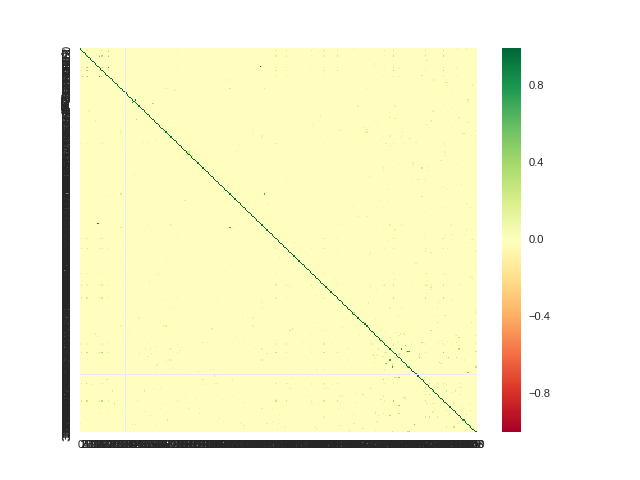

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib notebook

def plot_correlation_matrix(matrix):
    corr_matrix = np.corrcoef(matrix)
    plt.figure()
    sns.heatmap(corr_matrix, cmap='RdYlGn')
    
lexicon_ngrams = get_ngram_lexicon(ngram_range=(1,2))
cv = CountVectorizer(ngram_range=(1,2), stop_words=stopwords_pt, vocabulary= lexicon_ngrams);
M = cv.fit_transform(pos_data["texts"])

plot_correlation_matrix(M.toarray());